In [35]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# module for working with operating system
import os

# module for fetching item from its operand
from operator import itemgetter

# opencv library
import cv2
# computational library
import numpy as np
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim
# visualization library
import matplotlib.pyplot as plt  # pylint: disable=unused-import
# model zoo with pretrained models
import torchvision.models as models
# some extended pytorch primitives
import torch.nn.functional as F

# pretty progress bar
from tqdm.auto import tqdm  # pylint: disable=unused-import
# augmentation imports
from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import MultiStepLR


from collections import defaultdict, deque

import cv2
import collections
import os
import numpy as np

import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torchvision import transforms
import torchvision
import random
from torch.utils.data import DataLoader, Dataset, sampler
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip,VerticalFlip,Cutout,SmallestMaxSize,
                            ToGray, ShiftScaleRotate, Blur,Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor

import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [37]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def forward(self, logits, targets):
        ''' fastai.metrics.dice uses argmax() which is not differentiable, so it 
          can NOT be used in training, however it can be used in prediction.
          see https://github.com/fastai/fastai/blob/master/fastai/metrics.py#L53
        '''
        N = targets.size(0)
        preds = torch.sigmoid(logits)
        #preds = logits.argmax(dim=1) # do NOT use argmax in training, because it is NOT differentiable
        # https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/python/keras/backend.py#L96
        EPSILON = 1e-7
 
        preds_flat = preds.view(N, -1)
        targets_flat = targets.view(N, -1)
 
        intersection = (preds_flat * targets_flat).sum()#.float()
        union = (preds_flat + targets_flat).sum()#.float()
        
        loss = (2.0 * intersection + EPSILON) / (union + EPSILON)
        loss = 1 - loss / N
        return loss

In [38]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_func = DiceLoss() #nn.BCEWithLogitsLoss() 

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    lossf=None
    inner_tq = tqdm(data_loader, total=len(data_loader), leave=False, desc= f'Iteration {epoch}')
    for images, masks in inner_tq:
        y_preds = model(images.to(device))
        y_preds = y_preds['out'][:, 1, :, :] #

        loss = loss_func(y_preds, masks.to(device))

        if torch.cuda.device_count() > 1:
            loss = loss.mean() # mean() to average on multi-gpu.

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if lr_scheduler is not None:
            lr_scheduler.step()

        if lossf:
            lossf = 0.98*lossf+0.02*loss.item()
        else:
            lossf = loss.item()
        inner_tq.set_postfix(loss = lossf)

In [64]:
def init_semantic_segmentation_dataset(data_path,mode):
    """ Prepare Semantic Segmentation dataset

    Arguments:
        data_path (string): path to dataset.
        imgs_folder (string): path to images (related of the data_path).
        masks_folder (string): path to masks (related of the data_path).

    Initialise dataset as a list of pairs {"image": <path_to_image>, "mask": <path_to_mask>}.
    """
    if mode == "train":
        imgs_folder =str("train" )
        masks_folder=str("trainannot")
        names = os.listdir(os.path.join(data_path, imgs_folder))
        dataset = []
        for name in names:
            name_wth_ext = name.rsplit(".",1)[0] + '.png'
            dataset.append({
                "image": os.path.join(data_path, imgs_folder, name),
                "mask": os.path.join(data_path, masks_folder, name_wth_ext)
            })
    else:
        imgs_folder=str("test")
        names = os.listdir(os.path.join(data_path, imgs_folder))
        dataset = []
        for name in names:
            dataset.append({
                "image": os.path.join(data_path, imgs_folder, name),
            })

    return dataset

In [65]:
# dataset class implementation
class ImageData(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_url (string, optional): url to remote repository containing the dataset.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
    def __init__(
        self,
        data_path,
        mode,
        num_classes,
        transforms=None,
    ):

        self.num_classes = num_classes
        self.transforms = transforms
        # check wether dataset loading parameters exist
        # get the map of image-mask pairs
        self.mode = mode
        self.dataset = init_semantic_segmentation_dataset(data_path,self.mode)


    # get dataset's length
    def __len__(self):
        return len(self.dataset)

    # get item by index
    def __getitem__(self, idx):
            if self.mode == "train":
                img = Image.open(self.dataset[idx]["image"])#[..., ::-1]
                img = self.transforms(img)
                mask = Image.open(self.dataset[idx]["mask"])
                mask = self.transforms(mask)
                return img, mask
            else:
                img = Image.open(self.dataset[idx]["image"]) #[..., ::-1]
                img = self.transforms(img)
                mask =None
                return img
                    

In [41]:
data_transf = transforms.Compose([
                                  #transforms.Scale((256, 1600)),
                                  transforms.Resize(300),
                                  #HorizontalFlip(p=0.5),
                                  #VerticalFlip(p = 0.5),
                                  #Blur(),
                                  #Cutout(),
                                  #ShiftScaleRotate(),
                                  #GaussNoise(),
                                  #ToGray(),
                                  transforms.ToTensor()])

In [42]:
train_data = ImageData(data_path="data",mode="train",num_classes=12,transforms = data_transf)


In [43]:
train_data.dataset.__len__()

2096

In [44]:
model_ft = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)
NUM_GPUS = torch.cuda.device_count()
if NUM_GPUS > 1:
    model_ft = torch.nn.DataParallel(model_ft)
_ = model_ft.to(device)

In [45]:
data_loader = torch.utils.data.DataLoader(
    train_data, batch_size=4, shuffle=True, num_workers=NUM_GPUS,drop_last=True
)

In [46]:
# construct an optimizer
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

In [47]:
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

In [34]:
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch)
    lr_scheduler.step()

/media/hdd/tools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


KeyboardInterrupt: 

In [48]:
model_ft.load_state_dict(torch.load("./deeplabv3Resnet101.pth"))


<All keys matched successfully>

In [49]:
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.to(torch.device('cuda'))
#assert model_ft.training == False

model_ft.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [50]:
torch.save(model_ft.state_dict(), 'deeplabv3Resnet101.pth')
torch.cuda.empty_cache()

In [102]:
data_transf_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [103]:
test_data = ImageData(data_path="data",mode="test",num_classes=12,transforms = data_transf_test)

In [104]:
data_loader_test = torch.utils.data.DataLoader(
    test_data, batch_size=1, shuffle=True, num_workers=NUM_GPUS,drop_last=True
)

In [112]:
# sample execution (requires torchvision)
#input_image = Image.open(test_data.dataset[1]['image'])
len(data_loader_test.dataset)
data_loader_test.dataset.dataset

[{'image': 'data/test/10073374695675195041.jpg'},
 {'image': 'data/test/10137013040634915218.jpg'},
 {'image': 'data/test/10156205338923399277.jpg'},
 {'image': 'data/test/10167281261326785845.jpg'},
 {'image': 'data/test/10170168169782848403.jpg'},
 {'image': 'data/test/10239392742488873425.jpg'},
 {'image': 'data/test/10241524179068396065.jpg'},
 {'image': 'data/test/10295233321234276279.jpg'},
 {'image': 'data/test/10327726065195715462.jpg'},
 {'image': 'data/test/10350784365160863566.jpg'},
 {'image': 'data/test/1037567489359475910.jpg'},
 {'image': 'data/test/10482471169034963513.jpg'},
 {'image': 'data/test/10510586749145280892.jpg'},
 {'image': 'data/test/10536134137053835517.jpg'},
 {'image': 'data/test/10638559954484901158.jpg'},
 {'image': 'data/test/10646530246715543553.jpg'},
 {'image': 'data/test/1071434776534258354.jpg'},
 {'image': 'data/test/1079669000590963360.jpg'},
 {'image': 'data/test/10831511439934288249.jpg'},
 {'image': 'data/test/10891117201999956151.jpg'},
 {'

In [113]:
#input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
input_batch = data_loader_test.dataset[2].unsqueeze(0)
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model_ft.to('cuda')

with torch.no_grad():
    output = model_ft(input_batch)['out'][0]
output_predictions = output.argmax(0)

<IPython.core.display.Javascript object>


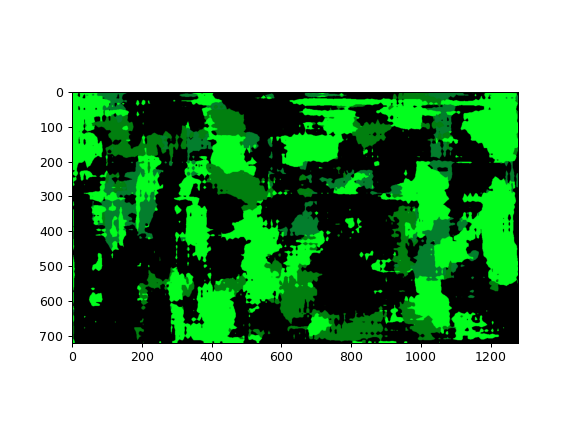

In [117]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 12 - 1])
colors = torch.as_tensor([i for i in range(12)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)
plt.imshow(r)
